In [1]:
import torch, random
from copy import deepcopy
import numpy as np
from torch import nn, optim
from torch.nn import ModuleList, functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import deque

# All the classes used
* **Board** the class responsible to for keeping track of the connect4 environment
* **NN** the neural network model used
* **Agent** handles the DQN algorithm


In [2]:
WIN = 10
class Board:
    dx = [1, 0, 1, -1]
    dy = [0, 1, 1, 1]
    def __init__(self) -> None:
        self.board = [[0]*6 for _ in range(7)]
        self.turn = 1
        self.played = set()
        self.win = None
        self.columns = [0] * 7

    def __str__(self):
        ret = ""
        for i in reversed(list(zip(*self.board))):
            ret += "|"
            for j in i:
                ret += str(j).rjust(3)
            ret += " |\n"
        return ret
    def play(self, col):
        if self.columns[col] >= 6: return
        self.board[col][self.columns[col]] = self.turn
        self.played.add((col, self.columns[col]))
        self.columns[col] += 1
        self.turn *= -1
        self.win = self.check_win()
        return self.win

    def reward(self, col=-1, *, inverted=1, turn=1):
        total = 0
        if col != -1:
            self.board[col][self.columns[col]] = turn
        for posx in range(7):
            for posy in range(6):
                color = self.board[posx][posy]
                if color == 0:
                    continue
                for k in range(4):
                    count = 1
                    multiplier = 2
                    length = 1
                    
                    for sign in [-1, 1]:
                        dead = False
                        stopped=False
                        for l in range(1, 4): 
                            r = posx + self.dx[k]*l*sign
                            c = posy + self.dy[k]*l*sign
                            if not (0 <= r < 7 and 0 <= c < 6):
                                if not dead: multiplier -= 1
                                break
                            if self.board[r][c] !=color:
                                if self.board[r][c] == -color: 
                                    if not dead: multiplier -= 1
                                    stopped=True
                                    break
                                dead = True
                            else:

                                if stopped: continue
                                count += 1
                            if stopped: continue
                            length += 1
                            
                            if count >= 4:
                                if col != -1: self.board[col][self.columns[col]] = 0
                                return 20*color
                    
                    if length < 4:
                        multiplier = 0
                    p = total
                    if color != turn:
                        multiplier += .5
                    total += (multiplier * count) **3/200 * (1 if color == turn else 1.5) * color
        if col != -1:
            self.board[col][self.columns[col]] = 0
        
        return total
   
       
    def inverted(self):
        return [[j*(-1) for j in i] for i in self.board]
    def check_win(self):
        for i, j in self.played:
            color = self.board[i][j]
            for k in range(4):
                for l in range(1, 4):
                    r = i + self.dx[k]*l 
                    c = j + self.dy[k]*l 
                    if not (0 <= r < 7 and 0 <= c < 6): break
                    if self.board[r][c] != color: break
                else:
                    return color
        if sum(self.columns) == 42: return 0
        return None
    def to_tensor(self, turn=None, *, make_batch=False):
        if make_batch:
            return torch.tensor([[self.board]], dtype=torch.float32)

        return torch.tensor([self.board], dtype=torch.float32)
    def legal(self):
        return {i for i in range(7) if self.columns[i] < 6}
    def filter_illegal_max(self, vals):
        m = None
        for i in self.legal():
            if m is None or vals[0][m]< vals[0][i]:
                m = i
        return m
    def filter_illegal_min(self, vals):
        m = None
        for i in self.legal():
            if m is None or vals[0][m]> vals[0][i]:
                m = i
        return m
    
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc0 = nn.Linear(42, 120)
        self.fc1 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 120)

        self.fc4 = nn.Linear(120, 70)
        self.fc5 = nn.Linear(70, 40)
        self.fc6 = nn.Linear(40, 7)
        for i in [self.fc0, self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]:
            nn.init.kaiming_normal_(i.weight)
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.0025)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))


        x = self.fc6(x)
        
        return x

BATCH_SIZE = 100
GAMMA = 0.9
class Agent:
    def __init__(self, first = True) -> None:
        self.model = NN()
        self.t_model = NN()
        self.update_t = 0
        self.exp = deque()
        self.interval = 5000
        self.episodes = 0
        self.wins = 0
        self.first = first
        self.win_x, self.win_y = [], []
        self.losses_x = []
        self.losses_y = []
        self.x = 0
        self.has = set()
        self.epsilon = 0
        self.board = Board()
        self.loss_f = nn.MSELoss()
        self.copy()
    def copy(self):
        self.t_model.load_state_dict(self.model.state_dict())
    
    def legal_mask(self, states):
        ret = []
        for board in states:
            row = [1 if 0 in col else 0 for col in board]
            ret.append(row)
        return torch.tensor(ret, dtype=torch.float32)

    def best_move(self, board=None, epsilon=False):
        if board is None:
            board = self.board
        if epsilon and random.random() > self.epsilon:
            return random.choice(list(board.legal()))
        a = (board.filter_illegal_max if self.first else board.filter_illegal_min)(self.model(board.to_tensor(make_batch=True)))
        return a
        
    def step(self, oppo=None):
        self.x += 1
        if not self.first and self.board.turn == 1:
            oppo_a = random.choice(list(self.board.legal())) if oppo is None else oppo.best_move(self.board, True)
            self.board.play(oppo_a)
        s = self.board.to_tensor()
        if random.random() < self.epsilon:
            a = self.best_move()
        else:
            a = random.choice(list(self.board.legal()))
        r = self.board.reward(turn=1 if self.first else -1)
        self.board.play(a)
        if self.board.win is None:
            oppo_a = random.choice(list(self.board.legal())) if oppo is None else oppo.best_move(self.board, True)
            self.board.play(oppo_a)
            r = 20*self.board.win if self.board.win in [-1, 1] else -r if self.board.win == 0 else self.board.reward(turn=1 if self.first else -1) - r
            new_s = self.board.to_tensor()
        else:
            new_s = self.board.to_tensor(-1)
            r = 0 if self.board.win == 0 else 20*self.board.win
        if (s, a, r, new_s) not in self.has:
            self.has.add((s, a, r, new_s))
            self.exp.append((s, a, r, new_s))
            if len(self.exp) > 30000:
                trans = self.exp.popleft()
                self.has.remove(trans)
        if len(self.exp) < BATCH_SIZE:
            return
        self.model.optimizer.zero_grad()
        batch = random.sample(self.exp, BATCH_SIZE)
        states, actions, rewards, new_states = zip(*batch)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        for _ in range(1):
            q = self.model(torch.stack(states)).gather(1, torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)).flatten(0)
            if self.first:
                target_q = (self.t_model(torch.stack(new_states))*self.legal_mask(new_states)).max(1)[0]*GAMMA + rewards
            else:
                target_q = (self.t_model(torch.stack(new_states))*self.legal_mask(new_states)).min(1)[0]*GAMMA + rewards
            loss = self.loss_f(q, target_q)
            
        self.update_t += 1
        if self.x % 500 == 0:
            self.losses_y.append(int(loss))
            self.losses_x.append(self.x)
        loss.backward()
        self.model.optimizer.step()
        if self.update_t >= self.interval:
            self.update_t = 0
            self.copy()
        if self.board.win is not None:
            self.episodes += 1
            if self.board.win == (1 if self.first else -1): self.wins += 1
            self.win_x.append(self.episodes)
            self.win_y.append(self.wins/self.episodes)
            self.epsilon = 1-0.9999**self.x
            self.board = Board()
        if self.x > 15000:
            self.interval = 100000
    

# Train DQN for player 1

Train DQN and save the agent to p1.dat

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [2:11:28<00:00, 126.77it/s] 


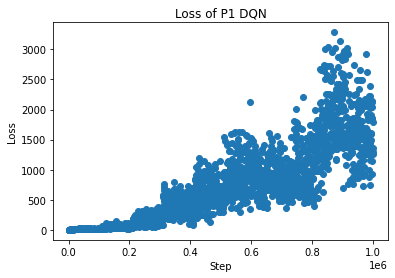

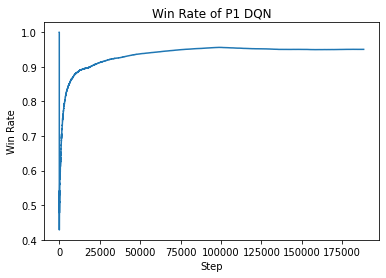

In [3]:
import pickle
board = Board()
try:
    with open("p1.dat", "rb") as f:
        p1 = pickle.load(f)
except FileNotFoundError:
    p1 = Agent(True)
try:
    for i in tqdm(range(1000000)):
        p1.step()
except KeyboardInterrupt:
    pass
with open("p1.dat", "wb") as f:
    pickle.dump(p1, f)
plt.scatter(p1.losses_x, p1.losses_y)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title("Loss of P1 DQN")
# plt.ylim([0, 2e7])
plt.savefig("p1_loss.png")
plt.show()
plt.plot(p1.win_x, p1.win_y)
plt.ylabel('Win Rate')
plt.xlabel('Step')
plt.title("Win Rate of P1 DQN")
# plt.ylim([0, 2e7])
plt.show()

# Train DQN for player 2

Train DQN and save the agent to p2.dat

In [4]:
print(Board().reward_of(3))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [157]:
board = Board()
p2 = Agent(board)
for i in range(1000):
    p2.step()


 70%|███████   | 700777/1000000 [1:27:31<37:22, 133.45it/s]  


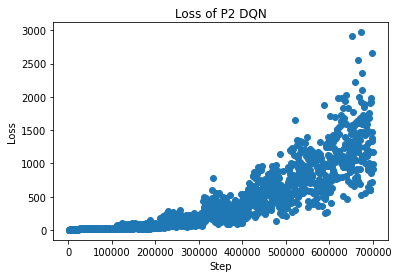

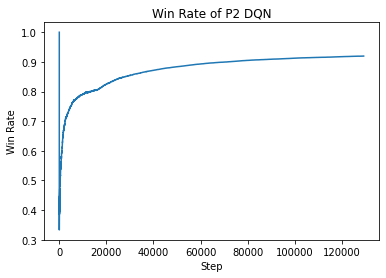

In [158]:
import pickle
board = Board()
try:
    with open("p2.dat", "rb") as f:
        p2 = pickle.load(f)
except FileNotFoundError:
    p2 = Agent(False)
try:
    for i in tqdm(range(1000000)):
        p2.step()
except KeyboardInterrupt:
    pass
with open("p2.dat", "wb") as f:
    pickle.dump(p2, f)
plt.scatter(p2.losses_x, p2.losses_y)
# plt.ylim([0, 2e7])
plt.ylabel('Loss')
plt.xlabel('Step')
plt.title("Loss of P2 DQN")
plt.savefig("p2_loss.png")
plt.show()

plt.plot(p2.win_x, p2.win_y)
plt.ylabel('Win Rate')
plt.xlabel('Step')
plt.title("Win Rate of P2 DQN")
# plt.ylim([0, 2e7])
plt.show()

# The two agents playing against each other

In [11]:
import pygame
surface = pygame.display.set_mode((700, 600))
board = Board()
def draw():
    surface.fill((0, 0, 0))
    for i in range(7):
        pygame.draw.line(surface, (255, 255, 255), (i*100, 0), (i*100, 600))
        pygame.draw.line(surface, (255, 255, 255), (0, i*100), (700, i*100))
        for j in range(6):
            if board.board[i][j]:
                pygame.draw.circle(surface, "red" if board.board[i][j] == 1 else "yellow", (i*100+50, 600-j*100-50), 40)
q = False
while board.win is None and not q:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            q = True
            break
        if event.type == pygame.MOUSEBUTTONDOWN:
            if board.turn == 1:
                values = p1.model(board.to_tensor(make_batch=True))
                # print(f"reward: {[board.reward_of(i) if i in board.legal() else 0 for i in range(7)]}")
                a = board.filter_illegal_max(values)
                r = board.reward(turn=1)
                print(f"AI1 played {a}: {values}")
                print(f"reward: {[board.reward(i, turn=1) - r if i in board.legal() else 0 for i in range(7)]}")
                board.play(a)
            else:
                values = p2.model(board.to_tensor(make_batch=True))
                # print(f"reward: {[board.reward_of(i) if i in board.legal() else 0 for i in range(7)]}")
                a = board.filter_illegal_min(values)
                r = board.reward(turn=-1)
                print(f"AI2 played {a}: {values}")
                print(f"reward: {[board.reward(i, turn=-1) - r if i in board.legal() else 0 for i in range(7)]}")
                board.play(a)
    draw()
    pygame.display.flip()
pygame.quit()


AI1 played 3: tensor([[108.9194, 100.5769, 126.7174, 144.9295, 122.1339, 100.6703,  65.6606]],
       grad_fn=<AddmmBackward>)
reward: [0.015, 0.049999999999999996, 0.049999999999999996, 0.05499999999999999, 0.049999999999999996, 0.049999999999999996, 0.015]
AI1 played 1: tensor([[ 91.4720, 130.9756,  92.1791,  35.9681,  42.1661,  87.9044,  77.1980]],
       grad_fn=<AddmmBackward>)
reward: [0.33, 0.6100000000000001, 0.6968750000000001, 0.14937500000000004, 0.696875, 0.6100000000000001, 0.33]
AI1 played 4: tensor([[ 54.8336,  98.0626, 102.2192,  90.4291, 108.5560, 105.4608,  49.2358]],
       grad_fn=<AddmmBackward>)
reward: [0.05500000000000005, 0.11499999999999991, 0.141875, 0.464375, 0.23624999999999996, 0.010000000000000009, 0.010000000000000009]
AI1 played 4: tensor([[ 54.8336,  98.0626, 102.2192,  90.4291, 108.5560, 105.4608,  49.2358]],
       grad_fn=<AddmmBackward>)
reward: [0.05500000000000005, 0.13937500000000003, 0.1418750000000002, 0.51, 0.3231250000000001, 0.0050000000000

# Estimating win rate of the agents against a random opponent


100%|██████████| 10000/10000 [00:17<00:00, 571.60it/s]


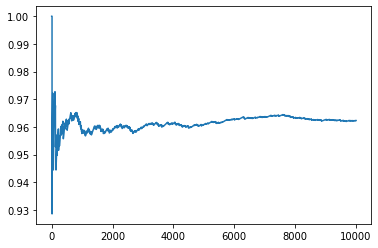

0.9623


In [5]:
wins = 0
episode = 0
win_rate = []
episodes = []
for _ in tqdm(range(10000)):
    board = Board()
    while board.win is None:
        a = p1.best_move(board) if board.turn == 1 else random.choice(list(board.legal()))
        board.play(a)
    if board.win == 1: wins += 1
    episode+=1
    win_rate.append(wins/episode)
    episodes.append(episode)
plt.plot(episodes, win_rate)
plt.show()
print(win_rate[-1])

100%|██████████| 10000/10000 [00:16<00:00, 613.40it/s]


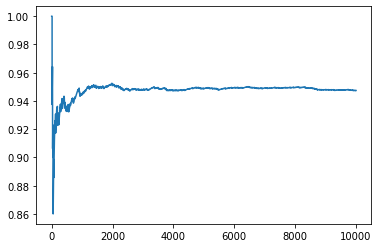

0.9474


In [6]:
wins = 0
episode = 0
win_rate = []
episodes = []
for _ in tqdm(range(10000)):
    board = Board()
    while board.win is None:
        a = p2.best_move(board) if board.turn == -1 else random.choice(list(board.legal()))
        board.play(a)
    if board.win == -1: wins += 1
    episode+=1
    win_rate.append(wins/episode)
    episodes.append(episode)
plt.plot(episodes, win_rate)
plt.show()
print(win_rate[-1])

# Attempt at training the two agents against each other instead of random opponent

The training resulted in worse performance against random opponents.

  0%|          | 241/50000 [00:04<15:24, 53.80it/s]


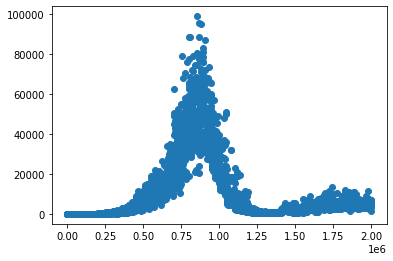

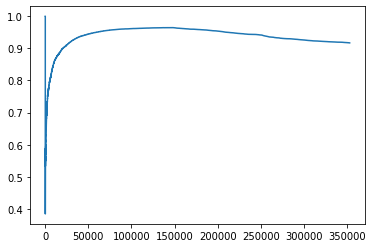

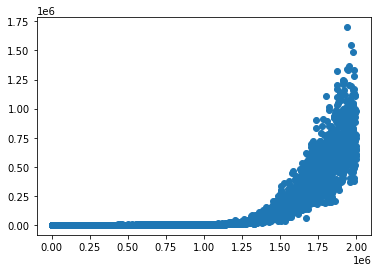

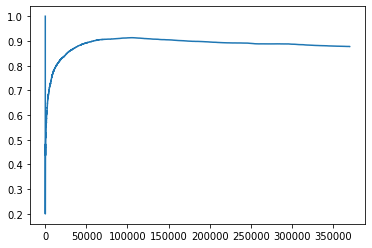

In [7]:
import pickle
board = Board()
try:
    with open("p1.dat", "rb") as f:
        p1 = pickle.load(f)
except FileNotFoundError:
    p1 = Agent(True)
try:
    with open("p2.dat", "rb") as f:
        p2 = pickle.load(f)
except FileNotFoundError:
    p2 = Agent(False)
try:
    for i in tqdm(range(50000)):
        p1.step(p2)
        p2.step(p1)
except KeyboardInterrupt:
    pass
with open("p1.dat", "wb") as f:
    pickle.dump(p1, f)
plt.scatter(p1.losses_x, p1.losses_y)
# plt.ylim([0, 2e7])
plt.show()
plt.plot(p1.win_x, p1.win_y)
# plt.ylim([0, 2e7])
plt.show()
with open("p2.dat", "wb") as f:
    pickle.dump(p2, f)
plt.scatter(p2.losses_x, p2.losses_y)
# plt.ylim([0, 2e7])
plt.show()
plt.plot(p2.win_x, p2.win_y)
# plt.ylim([0, 2e7])
plt.show()